# Data Ingestion

## Copy CSV files to S3

In [68]:
# Assume all the pre-requisites were set up 
%store -r setup_instance_check_passed
%store -r setup_dependencies_passed
%store -r setup_s3_bucket_passed
%store -r setup_iam_roles_passed


no stored variable or alias setup_instance_check_passed
no stored variable or alias setup_dependencies_passed
no stored variable or alias setup_s3_bucket_passed
no stored variable or alias setup_iam_roles_passed


In [69]:
# Load Libraries
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [4]:
# Public Data
!aws s3 ls s3://ads508team5/

# Copy Datasets from :
# Source of data
s3_public_path_tweeter = "s3://ads508team5/tweeter"
s3_public_path_nyt = "s3://ads508team5/nyt"

# Destination Data:

s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)

# Copy datasets
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_donaldtrump.csv"
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_joebiden.csv"
!aws s3 cp --recursive $s3_public_path_nyt/ $s3_private_path_nyt/ --exclude "*" --include "nyt-comments-2020.csv"


                           PRE nyt/
                           PRE tweeter/
copy: s3://ads508team5/tweeter/hashtag_donaldtrump.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/tweeter/hashtag_donaldtrump.csv
copy: s3://ads508team5/tweeter/hashtag_joebiden.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/tweeter/hashtag_joebiden.csv
copy: s3://ads508team5/nyt/nyt-comments-2020.csv to s3://sagemaker-us-east-1-851725336500/ADS508_project/nyt/nyt-comments-2020.csv


## Create Database, Tables and Parquets
### Database

In [70]:
# Setup and check pre-requisites to create Database
ingest_create_athena_db_passed = False

#!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [71]:
# Create Database
database_name = "dbpoliticpulsecomment"

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

# Verify DB successfully created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)


/tmp/ipykernel_103/419283915.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)
/tmp/ipykernel_103/419283915.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,dbpoliticpulsecomment
1,default
2,dsoaws
3,sagemaker_featurestore


In [72]:
# End of Create Database
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Tables

In [73]:
# Create Tweeter Tables
table_name_csv = "tweeter"
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
  created_at TIMESTAMP,
  tweet_id FLOAT,
  tweet VARCHAR(250),
  likes INT,
  retweet_count INT,
  source VARCHAR(45),
  user_id INT,
  user_name VARCHAR(250),
  user_screen_name VARCHAR(45),
  user_description VARCHAR(250),
  user_join_date TIMESTAMP,
  user_followers_count INT,
  user_location VARCHAR(45),
  lat FLOAT,
  long FLOAT,
  city VARCHAR(45),
  country VARCHAR(45),
  continent VARCHAR(45),
  state VARCHAR(45),
  state_code VARCHAR(45),
  collected_at VARCHAR(45)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_tweeter
)

pd.read_sql(statement, conn)


/tmp/ipykernel_103/1858324476.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [74]:
# testing hashtag_donaldtrump.csv tweet
tweet = "You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D"
# testing hashtag_joebiden.csv tweet
tweet = "@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden"


statement = """SELECT * FROM {}.{}
    WHERE tweet = '{}' LIMIT 100""".format(
    database_name, table_name_csv, tweet
)

df = pd.read_sql(statement, conn)
df.head(5)


/tmp/ipykernel_103/1253481606.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0,0,Twitter for iPhone,None,Michelle Ferg,MichelleFerg4,,...,27,,None,None,,,,,,2020-10-21 00:00:01.553481849


In [75]:
# Create NYT comment Table
table_name_csv = "nyt_comment"
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)


statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
  commentID INT,
  status VARCHAR(20),
  commentSequence INT,
  userID INT,
  userDisplayName VARCHAR(45),
  userLocation VARCHAR(45),
  userTitle VARCHAR(10),
  commentBody VARCHAR(500),
  createDate TIMESTAMP,
  updateDate TIMESTAMP,
  approveDate TIMESTAMP,
  recommendation INT,
  replyCount INT,
  editorsSelection VARCHAR(20),
  parentID INT,
  parentUserDisplayName VARCHAR(45),
  depth INT,
  commentType VARCHAR(20),
  trusted VARCHAR(20),
  recommendedFlag VARCHAR(20),
  permID INT,
  isAnonymous VARCHAR(20),
  articleID VARCHAR(150)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_nyt
)

pd.read_sql(statement, conn)


/tmp/ipykernel_103/1775205595.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [76]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_103/2201015668.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,tab_name
0,city
1,comment
2,comment_parquet
3,nyt_comment
4,tweeter


In [77]:
commentBody = "@Philip Brown Agree 110%."

statement = """SELECT * FROM {}.{}
    WHERE commentBody = '{}' LIMIT 100""".format(
    database_name, table_name_csv, commentBody
)

df = pd.read_sql(statement, conn)
df.head(5)


/tmp/ipykernel_103/1150646089.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,commentid,status,commentsequence,userid,userdisplayname,userlocation,usertitle,commentbody,createdate,updatedate,...,editorsselection,parentid,parentuserdisplayname,depth,commenttype,trusted,recommendedflag,permid,isanonymous,articleid
0,104389709,approved,104389709,72038931,Anthony Monaghan,Narrabeen,,@Philip Brown Agree 110%.,2020-01-01 10:36:20,2020-01-01 21:18:55,...,False,104389536,Philip Brown,2,userReply,0,0,104389709,False,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...


### Parquets
#### Feature Selection and Creation
Prior creating a parquet table, tweeter and NYT comment tables are going to be combined under Comment Table in Athena where a feature creation is going to be performed. When the table is combined, we selected some features that would be benefit to our goal.

Selected features which could help on train the model are comment_id, comment_body, user_id, user_location, candidatepoll

In [78]:
table_comment = "comment"
table_tweeter = "tweeter"
table_nyt_comment = "nyt_comment"

# SQL Statement combine tweeter and NYT comment in the preparation to create parquet
statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT 
    tweet_id AS comment_id,
    tweet AS comment_body,
    user_id AS user_id,
    user_name AS user_name,
    user_location AS user_location,
    created_at AS create_date,
    retweet_count AS reply_retweet,
    likes AS recommendation_like,
    'tweet' as source,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE 
        WHEN 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN              
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM
    {}.{}
WHERE
    LENGTH(tweet) > 3
UNION
SELECT 
    commentid AS comment_id,
    commentbody AS comment_body,
    userID AS user_id,
    userDisplayName AS user_name,
    userLocation AS user_location,
    createDate AS create_date,
    replyCount AS reply_retweet,
    recommendation AS recommendation_like,
    'nyt_comment' as source,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM 
    {}.{}
WHERE LENGTH(commentbody) > 3
)""".format(database_name, table_comment,database_name, table_tweeter,database_name, table_nyt_comment)

pd.read_sql(statement, conn)

/tmp/ipykernel_103/2540414611.py:64: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


,rows


In [79]:
commentbody = "Joe Biden"
source = "nyt_comment"

statement = """SELECT * FROM {}.{}
    WHERE comment_body like '{}%' and source = '{}' LIMIT 100""".format(
    database_name, table_comment, commentbody, source
)

df = pd.read_sql(statement, conn)
df.head(5)


/tmp/ipykernel_103/253224117.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,comment_id,comment_body,user_id,user_name,user_location,create_date,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,110811792.0,Joe Biden’s Climate Team Actually Cares About ...,70773801,Nreb,La La Land,2020-12-29 22:18:22,0,0,nyt_comment,0,1,Biden
1,109320808.0,Joe Biden just needs to be himself (comfortabl...,63221581,tippicanoe,Los Angeles,2020-09-27 03:07:51,2,45,nyt_comment,0,2,Biden
2,104423304.0,Joe Biden - Pete Buttigieg is the ticket.,67999402,Bruce Savin,Montecito,2020-01-03 17:25:06,1,2,nyt_comment,0,1,Biden
3,107414712.0,Joe Biden's just in time pandering disgusts me...,68748236,Civil,NC,2020-06-03 20:46:48,0,8,nyt_comment,1,1,None
4,106774664.0,Joe Biden is 'lurking' has to be the last thin...,65784050,kt,new jersey,2020-04-29 17:32:51,0,15,nyt_comment,0,1,Biden


In [80]:
# Setup to create Parquet
ingest_create_athena_table_parquet_passed = False

# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/ADS508_project/parquet".format(bucket)

table_parquet = "comment_parquet"

In [81]:
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['candidatepoll']) AS
SELECT DISTINCT comment_id,
         user_name,
         user_location,
         comment_body,
         source,
         candidatepoll
FROM {}.{}
where candidatepoll is not null AND Length(comment_body)>1 AND length(user_location)>1""".format(
    database_name, table_parquet, s3_path_parquet, database_name, table_comment
)
pd.read_sql(statement, conn)


/tmp/ipykernel_103/3973533100.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


,rows


In [82]:
#load the Parquet partitions
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_parquet)

df = pd.read_sql(statement, conn)
df.head(5)

/tmp/ipykernel_103/2260227216.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


""


In [83]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

/tmp/ipykernel_103/680368856.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_partitions = pd.read_sql(statement, conn)


,partition
0,candidatepoll=Biden
1,candidatepoll=Trump


In [84]:
statement = "SHOW TABLES in {}".format(database_name)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

/tmp/ipykernel_103/2954009692.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_partitions = pd.read_sql(statement, conn)


,tab_name
0,city
1,comment
2,comment_parquet
3,nyt_comment
4,tweeter


In [85]:
candidatepoll = "Trump"

statement = """SELECT * FROM {}.{}
    Where candidatepoll = '{}' LIMIT 10""".format(
    database_name, table_parquet, candidatepoll
)
df_parquet = pd.read_sql(statement, conn)
df_parquet.head(5)

/tmp/ipykernel_103/1824229899.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_parquet = pd.read_sql(statement, conn)


,comment_id,user_location,comment_body,source,candidatepoll
0,106321952.0,Los Angeles,Why does trump lie?,nyt_comment,Trump
1,106329240.0,Camas WA,American colonists fought a bloody revolution ...,nyt_comment,Trump
2,110825048.0,LINY,"""Oh Bret. You just cant let go can you? Always...",nyt_comment,Trump
3,110839632.0,usa,"""Trumpism has demonstrated that a large part o...",nyt_comment,Trump
4,110840736.0,California,"""The Trump administration has been a disaster ...",nyt_comment,Trump


## Query Data

In [86]:
# Setup and check pre-requisites to create Database

#!pip install --disable-pip-version-check -q awswrangler
import awswrangler as wr

In [87]:
t_filter = lambda x: x["candidatepoll"] == "Trump"
b_filter = lambda x: x["candidatepoll"] == "Biden"

In [88]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=t_filter, dataset=True
)

df_parquet_results_trump = df_parquet_results.drop_duplicates(subset = ['comment_body'])

In [89]:
df_parquet_results_trump.shape

(670045, 4)

In [90]:
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll
0,Why does trump lie?,nyt_comment,Los Angeles,Trump
1,American colonists fought a bloody revolution ...,nyt_comment,Camas WA,Trump
2,"""Oh Bret. You just cant let go can you? Always...",nyt_comment,LINY,Trump
3,"""Trumpism has demonstrated that a large part o...",nyt_comment,usa,Trump
4,"""The Trump administration has been a disaster ...",nyt_comment,California,Trump


In [91]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

# Call all public discourse data from 
df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=b_filter, dataset=True
)


df_parquet_results_biden = df_parquet_results.drop_duplicates(subset = ['comment_body'])
df_parquet_results_biden.shape


(260435, 4)

In [27]:
df_parquet_results_biden.head(5)

,comment_body,source,user_location,candidatepoll
0,#Cubanos por #Biden sacan las uñas para defend...,tweet,"""Miami",Biden
1,"""#Biden promete firmar una orden ejecutiva par...",tweet,<NA>,Biden
2,"""@Fxhedgers 3 Trillion Stimulus will be passed...",tweet,<NA>,Biden
3,America’s next president = Democratic af. #Kam...,tweet,2020-07-30 14:42:29,Biden
4,"""Here's the next thing Joe Biden says he will ...",tweet,<NA>,Biden


# Data Exploration

In [28]:
# Checking for missing values from trump data
df_parquet_results_trump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926684 entries, 0 to 333283
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   926684 non-null  string  
 1   source         926684 non-null  string  
 2   user_location  734725 non-null  string  
 3   candidatepoll  926684 non-null  category
dtypes: category(1), string(3)
memory usage: 29.2 MB


In [29]:
# Check for missing values from  biden data
df_parquet_results_biden.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434926 entries, 0 to 163918
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   434926 non-null  string  
 1   source         434926 non-null  string  
 2   user_location  309555 non-null  string  
 3   candidatepoll  434926 non-null  category
dtypes: category(1), string(3)
memory usage: 13.7 MB


In [30]:
# Data Distributions for Trump and Biden 
df_parquet_results_trump['source'].value_counts()


tweet          534174
nyt_comment    392510
Name: source, dtype: Int64

In [31]:
# Data Distributions for Trump and Biden 
df_parquet_results_biden['source'].value_counts()

tweet          373106
nyt_comment     61820
Name: source, dtype: Int64

In [32]:
# Filtering Data by Location 
df_parquet_results_trump['user_location'].value_counts()

                        64393
NYC                     13502
California              11827
New York                11436
USA                      8575
                        ...  
2009-05-23 18:26:05         1
 Bojack                     1
"norton shores              1
Berlin & Brandenburg        1
 keto athlete               1
Name: user_location, Length: 94255, dtype: Int64

In [33]:
# Top 30 locations of social media activity
df_parquet_results_trump['user_location'].value_counts().head(30)

                 64393
NYC              13502
California       11827
New York         11436
USA               8575
Chicago           6948
Los Angeles       6684
NY                6620
San Francisco     6229
Seattle           6036
Florida           5700
NJ                5522
Boston            5312
United States     4949
New York City     4227
Canada            4204
New Jersey        3986
Colorado          3781
Brooklyn          3735
Texas             3713
CA                3478
Philadelphia      3155
Massachusetts     2763
Oregon            2756
Virginia          2723
Atlanta           2689
San Diego         2525
NC                2393
Maryland          2391
Midwest           2297
Name: user_location, dtype: Int64

In [34]:
df_parquet_results_biden['user_location'].value_counts()

                                                 49138
United States                                     3483
New York                                          2485
NYC                                               2395
USA                                               2281
                                                 ...  
Merseyside (he/him)                                  1
 and miraculous so add to the joy                    1
 nature-loving rescue puppers with tweetable         1
Jandiland                                            1
 50+ male from Malta. Interested in current a        1
Name: user_location, Length: 73592, dtype: Int64

In [35]:
# Top 30 locations of social media activity
df_parquet_results_biden['user_location'].value_counts().head(30)

                 49138
United States     3483
New York          2485
NYC               2395
USA               2281
California        1806
NY                1298
"Los Angeles      1229
"New York         1223
Chicago           1140
Los Angeles       1088
San Francisco     1085
Seattle            982
Florida            982
"California        969
Boston             847
"Washington        793
NJ                 790
Texas              760
Virginia           759
Canada             718
"Florida           716
New York City      711
New Jersey         672
Brooklyn           630
"London            611
CA                 575
Colorado           560
Earth              558
"Texas             556
Name: user_location, dtype: Int64

# Create EDA Overview Data Visualization

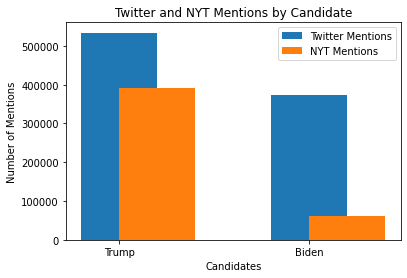

In [36]:
# Data Sources for Each Candidate
# Code from ChatGPT

import matplotlib.pyplot as plt

candidate = ['Trump','Biden']
twitter_n = [df_parquet_results_trump['source'].value_counts()[0],df_parquet_results_biden['source'].value_counts()[0]]
nyt_n = [df_parquet_results_trump['source'].value_counts()[1],df_parquet_results_biden['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

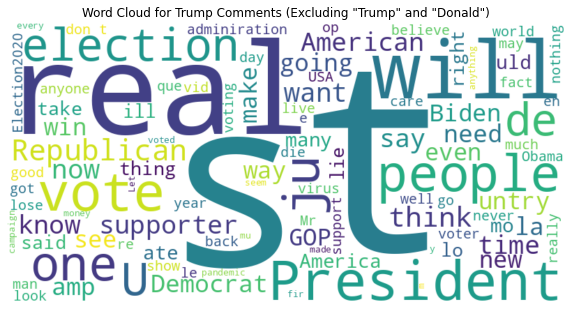

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Sample a subset of comments for generating the word cloud
sampled_trump_comments = df_parquet_results_trump['comment_body'].dropna().sample(n=10000, random_state=42)

# Concatenate sampled comments for Trump
trump_comments_text = ' '.join(sampled_trump_comments)

# Define words and patterns to exclude
words_to_exclude = ['trump', 'donald', 'donaldtrump', 'https', 'co', 'st'] 
patterns_to_exclude = [r'\btrump\b', r'\bdonald\b', r'\bdonaldtrump\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
trump_comments_text_cleaned = re.sub(exclude_patterns, '', trump_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Trump comments with a limit on the number of words
wordcloud_trump = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(trump_comments_text_cleaned)

# Plot the word cloud for Trump
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_trump, interpolation='bilinear')
plt.title('Word Cloud for Trump Comments (Excluding "Trump" and "Donald")')
plt.axis('off')
plt.show()

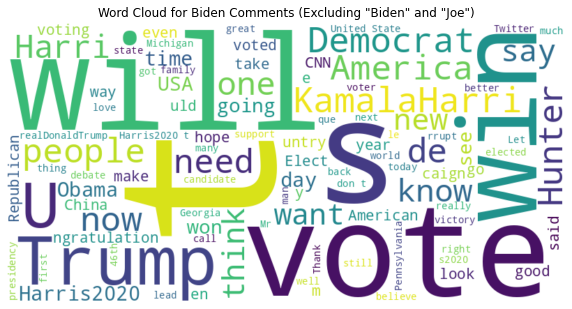

In [38]:
# Sample a subset of comments for Biden
sampled_biden_comments = df_parquet_results_biden['comment_body'].dropna().sample(n=40000, random_state=42)

# Concatenate sampled comments for Biden
biden_comments_text = ' '.join(sampled_biden_comments)

# Define words and patterns to exclude
words_to_exclude = ['biden', 'joe', 'joebiden', 'president', 'election', 'https', 'co','amp']  # Exclude common words and URLs
patterns_to_exclude = [r'\bbiden\b', r'\bjoe\b', r'\bjoebiden\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
biden_comments_text_cleaned = re.sub(exclude_patterns, '', biden_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Biden comments with a limit on the number of words
wordcloud_biden = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(biden_comments_text_cleaned)

# Plot the word cloud for Biden
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_biden, interpolation='bilinear')
plt.title('Word Cloud for Biden Comments (Excluding "Biden" and "Joe")')
plt.axis('off')
plt.show()

# Sentiment Labels Using Textblob

In [39]:
# Code from ChatGPT
#!pip install textblob
from textblob import TextBlob

def analyze_tweet_sentiment(tweet_text):
    analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    return analysis.sentiment.polarity


In [40]:
# Apply sentiment labels to Trump Data
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_trump = df_parquet_results_trump[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_trump['sentiment_score'] = df_tweets_trump['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_trump['sentiment'] = df_tweets_trump['sentiment_score']


/tmp/ipykernel_10829/3047377100.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_trump['sentiment_score'] = df_tweets_trump['comment_body'].apply(analyze_tweet_sentiment)


In [41]:
 # Apply Sentiment labels to Biden Data       
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_biden = df_parquet_results_biden[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_biden['sentiment_score'] = df_tweets_biden['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


/tmp/ipykernel_10829/1914027081.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_biden['sentiment_score'] = df_tweets_biden['comment_body'].apply(analyze_tweet_sentiment)
/tmp/ipykernel_10829/1914027081.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


## Trump

In [42]:
# Examine Trump Sentiment distribution
df_parquet_results_trump['sentiment'].value_counts()

 0.000000    451971
 0.500000     26665
 0.200000     16753
 0.250000     15819
-0.500000     11778
              ...  
-0.010000         1
-0.004329         1
 0.075824         1
 0.028571         1
-0.200397         1
Name: sentiment, Length: 28260, dtype: int64

In [43]:
# look at sample of tweets for negative sentiment
df_parquet_results_trump[df_parquet_results_trump['sentiment'] < 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
13,I’m really not understanding the people that c...,tweet,2012-10-20 15:04:32,Trump,-0.090000
22,"""@washingtonpost 🔴Trump has failed with #COVID19",tweet,2013-08-11 15:50:13,Trump,-0.500000
27,#Biden yelling from the podiums about #TRUMP m...,tweet,2009-05-04 19:48:56,Trump,-0.800000
39,@realDonaldTrump The only one #Biden will be l...,tweet,"""Wilkes-Barre",Trump,-0.077778
50,8 years of #Obiden was way too long! #JoeBiden...,tweet,"""Tennessee",Trump,-0.062500


In [44]:
# look at sample of tweets for neutral sentiment
df_parquet_results_trump[df_parquet_results_trump['sentiment'] == 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
2,"""@BrettFavre @realDonaldTrump Principle’s are ...",tweet,<NA>,Trump,0.0
3,"""Anything Trump can do",tweet,2626.0,Trump,0.0
5,"""@BrettFavre @Qanon76 @realDonaldTrump Please ...",tweet,91.0,Trump,0.0
6,"""@realDonaldTrump I’m going to guess",tweet,2019-08-08 17:25:45,Trump,0.0
8,"""@DiamondandSilk @realDonaldTrump @RSBNetwork ...",tweet,91.0,Trump,0.0


In [45]:
# look at sample of tweets for positive sentiment
df_parquet_results_trump[df_parquet_results_trump['sentiment'] > 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
0,"""WIN = trump https://t.co/v4yRMK4rrX",tweet,<NA>,Trump,0.800000
1,"""@realDonaldTrump EVRRYONE KNOWS. WELL ANYONE ...",tweet,<NA>,Trump,0.600000
4,"""Trump is winning.",tweet,<NA>,Trump,0.500000
7,"""""""Real Americans"""" for Trump ad ;)",tweet,<NA>,Trump,0.225000
15,"""@realDonaldTrump There is literally nothing m...",tweet,<NA>,Trump,0.152381


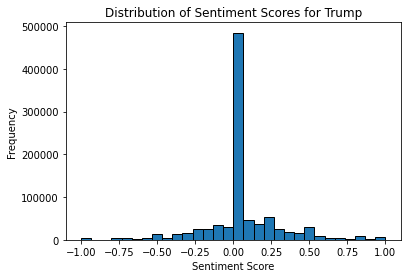

In [46]:
plt.hist(df_parquet_results_trump['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Trump')

# Show plot
plt.savefig('TrumpSentDist.png')

## Biden

In [47]:
# Examine Biden Sentiment distribution
df_parquet_results_biden['sentiment'].value_counts()

 0.000000    258794
 0.500000     12207
 0.800000      8162
 0.250000      6510
 0.200000      5782
              ...  
 0.051190         1
 0.292361         1
-0.042593         1
 0.173295         1
 0.201852         1
Name: sentiment, Length: 12118, dtype: int64

In [48]:
# look at sample of tweets for negative sentiment
df_parquet_results_biden[df_parquet_results_biden['sentiment'] < 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
9,"""@ossoff @common 3 Trillion Stimulus will be p...",tweet,<NA>,Biden,-0.300000
20,@SteveGuest So is #TonyBobulinski lying when h...,tweet,2020-10-09 19:24:36,Biden,-0.400000
31,"""The war in #Yemen may not last long into a #B...",tweet,<NA>,Biden,-0.025000
39,"""@MSNBC Total crap and #fakenews. The laptop ...",tweet,2020-10-20 19:52:13,Biden,-0.100000
50,Over #250k dead Americans endorse #joebiden fr...,tweet,"""Dallas",Biden,-0.031818


In [49]:
# look at sample of tweets for neutral sentiment
df_parquet_results_biden[df_parquet_results_biden['sentiment'] == 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
0,#Cubanos por #Biden sacan las uñas para defend...,tweet,"""Miami",Biden,0.0
1,"""#Biden promete firmar una orden ejecutiva par...",tweet,<NA>,Biden,0.0
2,"""@Fxhedgers 3 Trillion Stimulus will be passed...",tweet,<NA>,Biden,0.0
3,America’s next president = Democratic af. #Kam...,tweet,2020-07-30 14:42:29,Biden,0.0
4,"""Here's the next thing Joe Biden says he will ...",tweet,<NA>,Biden,0.0


In [50]:
# look at sample of tweets for positive sentiment
df_parquet_results_biden[df_parquet_results_biden['sentiment'] > 0].head(5)

,comment_body,source,user_location,candidatepoll,sentiment
8,Is it true? #Biden https://t.co/ly76Q5NVgm,tweet,<NA>,Biden,0.350000
15,You’re not black if you don’t vote Democrat -B...,tweet,,Biden,0.083333
21,Michigan Democratic Rep. Dingell: 'So many' au...,tweet,,Biden,0.500000
38,"""Vote #Biden if you like to pay more taxes. If...",tweet,<NA>,Biden,0.500000
48,Rounding the curve so much we’re going in circ...,tweet,31.0,Biden,0.200000


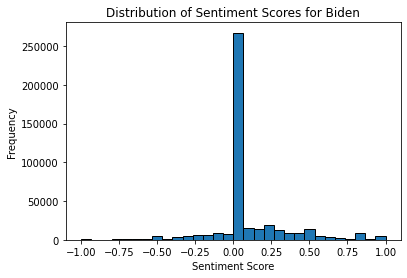

In [51]:
plt.hist(df_parquet_results_biden['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Biden')

# Show plot
plt.savefig('BidenSentDist.png')

## Preliminary Location Maps of Social Media Activity

In [52]:
# Color Sentiment on Scale from Blue to Red going dark to light as it approaches neutral

# Overlappint popular cities
trump_cities = []
biden_cities = []

# Plot sentiment for cities



# Data Bias

## Prepare Dataset for Bias Analysis

In [53]:
#import boto3
#import sagemaker
#import pandas as pd

#sess = sagemaker.Session()
#bucket = sess.default_bucket()
#role = sagemaker.get_execution_role()
#region = boto3.Session().region_name
#account_id = boto3.client("sts").get_caller_identity().get("Account")

#sm = boto3.Session().client(service_name="sagemaker", region_name=region)

#from pyathena import connect

#s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
#database_name = "dbpoliticpulsecomment"
#conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

#from textblob import TextBlob

#def analyze_tweet_sentiment(tweet_text):
    #analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    #return analysis.sentiment.polarity


# **********************DELETE PORTION ON THE TOP WHEN IT'S FINAL*************************



# We can just combine the df_parquet_results_biden and df_parquet_results_trump versus calling another query and running sentiment analysis again. Saves computational time.

In [54]:
#table_comment = "comment"

#statement = """SELECT comment_body, source, candidatepoll FROM {}.{}
#WHERE candidatepoll is not Null
    #""".format(
    #database_name, table_comment
#)
#df_combined = pd.read_sql(statement, conn)
#df_combined = df_combined.drop_duplicates()
#df_combined.info()

In [55]:
# Run sentiment analysis textblob for all candidate
#if __name__ == "__main__":
    # Assuming you have a DataFrame named df_comment with a column 'text' containing tweet text
    #df_comment_all = df_combined[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    #df_comment_all['sentiment_score'] = df_combined['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
#df_combined['sentiment'] = df_comment_all['sentiment_score']


In [98]:
df_combined = pd.concat([df_parquet_results_biden, df_parquet_results_trump], ignore_index=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361610 entries, 0 to 1361609
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   comment_body        1361610 non-null  string 
 1   source              1361610 non-null  string 
 2   user_location       1044280 non-null  string 
 3   candidatepoll       1361610 non-null  object 
 4   sentiment           1361610 non-null  float64
 5   sentiment_category  1361610 non-null  object 
dtypes: float64(1), object(2), string(3)
memory usage: 62.3+ MB


<AxesSubplot:xlabel='sentiment_category', ylabel='count'>

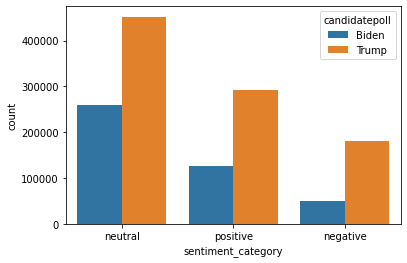

In [58]:
import seaborn as sns
df_combined['sentiment_category'] = df_combined['sentiment'].apply(lambda x: 'negative' if x < 0 else ('neutral' if x == 0 else 'positive'))
df_combined.info()
sns.countplot(data=df_combined, x="sentiment_category", hue="candidatepoll")\plt.title('Count Plot for Outcome Variable')
plt.xlabel('Sentiment Categories for Candidates')
plt.ylabel('Count')

# Feature Engineering and Data Preprocessing

## Create Outcome Labels: 6 Outcomes

In [76]:
df_combined['SentimentOutcome'] = df_combined['candidatepoll']+"_"+df_combined['sentiment_category']

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Biden_neutral'),
  Text(1, 0, 'Biden_positive'),
  Text(2, 0, 'Biden_negative'),
  Text(3, 0, 'Trump_positive'),
  Text(4, 0, 'Trump_neutral'),
  Text(5, 0, 'Trump_negative')])

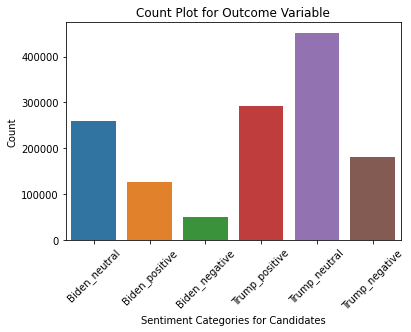

In [77]:
# Create count plot
sns.countplot(x=df_combined['SentimentOutcome'])

# Add title and labels
plt.title('Count Plot for Outcome Variable')
plt.xlabel('Sentiment Categories for Candidates')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Location Data: Top 5 States

In [101]:
# Read csv US City from S3 ---> PLANNING TO MOVE IT IN .py AND USE PREPROCESSING JOB FROM SAGEMAKER
git_city_loc = "https://raw.githubusercontent.com/HNStaggs/ADS508_GroupProject/main/uscities.csv"
df_city = pd.read_csv(git_city_loc)

df_combined['user_location'].head(5)

0         Maryland
1          Indiana
2    Whitestown IN
3        Eureka CA
4         Kentucky
Name: user_location, dtype: string

In [106]:
# PREFER TO RUN IT IN .py with SageMaker processing job
# TRY IT WITH 100 RECORD ONLY


# Create master location table
master_location = df_city
df_combined = df_combined.head(100)

# Function to map city and state name to state ID
def map_state_id(city):
    for index, loc in master_location.iterrows():
        if city.lower() == loc['city'].lower() or city.lower() == loc['state_name'].lower():
            return loc['state_id']
    return None

# Apply mapping function to user location table
df_combined['State ID'] = df_combined['user_location'].apply(map_state_id)

# Display the user location table with State ID column added


                                        comment_body       source  \
0  "@Dr. Girl We only just barely got BIDEN elect...  nyt_comment   
1  I've always thought Joe Biden was underrated. ...  nyt_comment   
2  "I’ve seen a lot of Biden in the last few week...  nyt_comment   
3  "In the midst of today's press conference at t...  nyt_comment   
4        "When is Biden going to start campaigning?   nyt_comment   

   user_location candidatepoll State ID  
0       Maryland         Biden       MD  
1        Indiana         Biden       IN  
2  Whitestown IN         Biden     None  
3      Eureka CA         Biden     None  
4       Kentucky         Biden       KY  


/tmp/ipykernel_103/2010171188.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['State ID'] = df_combined['user_location'].apply(map_state_id)


In [108]:
print(df_combined.head(100))


                                         comment_body       source  \
0   "@Dr. Girl We only just barely got BIDEN elect...  nyt_comment   
1   I've always thought Joe Biden was underrated. ...  nyt_comment   
2   "I’ve seen a lot of Biden in the last few week...  nyt_comment   
3   "In the midst of today's press conference at t...  nyt_comment   
4         "When is Biden going to start campaigning?   nyt_comment   
..                                                ...          ...   
95  Why Are Republicans So Afraid of Voters?: I do...        tweet   
96  hey @ladygaga just voted blue!! #Biden #BidenH...        tweet   
97  #IVOTED !!!!!!!!!!!!!!! Went for #Blue and vot...        tweet   
98  Hi @ladygaga! #IVoted ￼ for #Biden today! Insp...        tweet   
99  #JoeBiden @JoeBiden #BidenHarris2020 https://t...        tweet   

    user_location candidatepoll State ID  
0        Maryland         Biden       MD  
1         Indiana         Biden       IN  
2   Whitestown IN         Bide

# Create Final Dataset of Features

In [78]:
from collections import defaultdict
 
# Create ID variable
id_list = df_combined.index
temp = defaultdict(lambda: len(temp))
id_relabel = [temp[id] for id in id_list]
df_combined['review_id'] = pd.to_numeric(id_relabel)+1

# Create final dataset with outcome variable and comment body
df_final = df_combined[['review_id', 'comment_body', 'user_location', 'source', 'SentimentOutcome']]

In [79]:
df_final.head()

,review_id,comment_body,user_location,source,SentimentOutcome
0,1,#Cubanos por #Biden sacan las uñas para defend...,"""Miami",tweet,Biden_neutral
1,2,"""#Biden promete firmar una orden ejecutiva par...",<NA>,tweet,Biden_neutral
2,3,"""@Fxhedgers 3 Trillion Stimulus will be passed...",<NA>,tweet,Biden_neutral
3,4,America’s next president = Democratic af. #Kam...,2020-07-30 14:42:29,tweet,Biden_neutral
4,5,"""Here's the next thing Joe Biden says he will ...",<NA>,tweet,Biden_neutral


# Store Final Data in S3 Bucket

In [68]:
#Create folder
!mkdir -p ./data-clarify/

In [70]:
# chatgpt
# list folder
import os

# Get the current working directory
current_directory = "/home/sagemaker-user/ADS508_GroupProject"

In [81]:
# All Data
path = "./data-clarify/tweet_nyt_combined.csv"
df_final.to_csv(path, index=False, header=True)

In [102]:
# Create folder for specific timestamp
import time

timestamp = int(time.time())

all_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path)
all_data_s3_uri


's3://sagemaker-us-east-1-851725336500/ADS508_project/bias-detection-1711077522/tweet_nyt_combined.csv'

In [103]:
!aws s3 ls $all_data_s3_uri

2024-03-22 03:18:43  225099075 tweet_nyt_combined.csv


# Text Preprocessing with DistilBERT and Train/Test/Split

In [104]:
#!pip install transformers
import transformers
import tensorflow as tf
import collections
import json
import os
import pandas as pd
import csv
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


2024-03-22 03:20:10.261247: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-03-22 03:20:10.261300: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [105]:
REVIEW_BODY_COLUMN = "comment_body"

# Update IDs to start from 1
from collections import defaultdict
 
REVIEW_ID_COLUMN = "review_id"

LABEL_COLUMN = "SentimentOutcome"
LABEL_VALUES = ['Bidennegative', 'Bidenneutral', 'Bidenpositive', 'Trumpnegative', 'Trumpneutral', 'Trumppositive']


In [106]:
#!pygmentize preprocess-scikit-text-to-bert-feature-store.py

Error: cannot read infile: [Errno 2] No such file or directory: 'preprocess-scikit-text-to-bert-feature-store.py'


In [107]:
import time
from smexperiments.experiment import Experiment

timestamp = int(time.time())

experiment = Experiment.create(
    experiment_name="PoliticPulse-BERT-Experiment-{}".format(timestamp),
    description="Politic Pulse BERT Experiment",
    sagemaker_boto_client=sm,
)

experiment_name = experiment.experiment_name
print("Experiment name: {}".format(experiment_name))

Experiment name: PoliticPulse-BERT-Experiment-1711077711


In [108]:
from smexperiments.trial import Trial

trial = Trial.create(
    trial_name="trial-{}".format(timestamp), experiment_name=experiment_name, sagemaker_boto_client=sm
)

trial_name = trial.trial_name
print("Trial name: {}".format(trial_name))

Trial name: trial-1711077711


In [109]:
experiment_config = {
    "ExperimentName": experiment_name,
    "TrialName": trial_name,
    "TrialComponentDisplayName": "prepare",
}

In [110]:
print(experiment_name)
%store experiment_name

PoliticPulse-BERT-Experiment-1711077711
Stored 'experiment_name' (str)


In [111]:
print(trial_name)
%store trial_name

trial-1711077711
Stored 'trial_name' (str)


In [112]:
featurestore_runtime = boto3.Session().client(service_name="sagemaker-featurestore-runtime", region_name=region)

In [113]:
feature_store_offline_prefix = "reviews-feature-store-" + str(timestamp)

print(feature_store_offline_prefix)

reviews-feature-store-1711077711


In [114]:
feature_group_name = "reviews-feature-group-" + str(timestamp)

print(feature_group_name)

reviews-feature-group-1711077711


In [115]:
from sagemaker.feature_store.feature_definition import (
    FeatureDefinition,
    FeatureTypeEnum,
)

feature_definitions = [
    FeatureDefinition(feature_name="input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="segment_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label_id", feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name="review_id", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="date", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label", feature_type=FeatureTypeEnum.INTEGRAL),
    #    FeatureDefinition(feature_name='review_body', feature_type=FeatureTypeEnum.STRING)
]

In [116]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(name=feature_group_name, feature_definitions=feature_definitions, sagemaker_session=sess)

print(feature_group)

FeatureGroup(name='reviews-feature-group-1711077711', sagemaker_session=<sagemaker.session.Session object at 0x7f6e3889de80>, feature_definitions=[FeatureDefinition(feature_name='input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='segment_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='label_id', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>), FeatureDefinition(feature_name='review_id', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='date', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='label', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>)])


In [117]:
processing_instance_type = "ml.c5.xlarge"
processing_instance_count = 2
train_split_percentage = 0.90
validation_split_percentage = 0.05
test_split_percentage = 0.05
balance_dataset = True
max_seq_length = 64

In [118]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={"AWS_DEFAULT_REGION": region},
    max_runtime_in_seconds=7200,
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


# Need to find preprocess file and update to our destination location

In [119]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

processor.run(
    code="preprocess-scikit-text-to-bert-feature-store.py",
    inputs=[
        ProcessingInput(
            input_name="raw-input-data",
            source=all_data_s3_uri,
            destination="/opt/ml/processing/input/data/",
            s3_data_distribution_type="ShardedByS3Key",
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="bert-train", s3_upload_mode="EndOfJob", source="/opt/ml/processing/output/bert/train"
        ),
        ProcessingOutput(
            output_name="bert-validation",
            s3_upload_mode="EndOfJob",
            source="/opt/ml/processing/output/bert/validation",
        ),
        ProcessingOutput(
            output_name="bert-test", s3_upload_mode="EndOfJob", source="/opt/ml/processing/output/bert/test"
        ),
    ],
    arguments=[
        "--train-split-percentage",
        str(train_split_percentage),
        "--validation-split-percentage",
        str(validation_split_percentage),
        "--test-split-percentage",
        str(test_split_percentage),
        "--max-seq-length",
        str(max_seq_length),
        "--balance-dataset",
        str(balance_dataset),
        "--feature-store-offline-prefix",
        str(feature_store_offline_prefix),
        "--feature-group-name",
        str(feature_group_name),
    ],
    experiment_config=experiment_config,
    logs=True,
    wait=False,
)

ValueError: code preprocess-scikit-text-to-bert-feature-store.py wasn't found. Please make sure that the file exists.
                    

# Tranformation Pipeline

In [ ]:
cats_list = ['user_location', 'source']

# Create a categorical processing pipeline that uses one-hot encoding, dropping binary columns.
cat_pipe = Pipeline([('encoder', OneHotEncoder(drop='if_binary'))])

# Combine pipeline steps
all_pipe = make_pipeline(ColumnTransformer([('cat', cat_pipe, cats_list)],
                                          verbose_feature_names_out=False))
# Verify steps
all_pipe.named_steps

# Combine Transformed Features with BERT Transformed Text Data

# Make New Folders with Clean Datasets

In [ ]:
#Create folder
#!mkdir -p ./data-clarify/

In [ ]:
# chatgpt
# list folder
#import os

# Get the current working directory
#current_directory = "/home/sagemaker-user/ADS508_GroupProject"
#spec_dir = "/home/sagemaker-user/ADS508_GroupProject/data-clarify"

# List the contents of the directory
#for item in os.listdir(spec_dir):
    #full_path = os.path.join(spec_dir, item)
    #if os.path.isdir(full_path):
        #print(f"Directory: {item}")
    #else:
        #print(f"File: {item}")

In [ ]:
# All Data
#path = "./data-clarify/tweet_nyt_combined.csv"
#df_combined.to_csv(path, index=False, header=True)

In [ ]:
# Balance the Dataset by candidate and Sentiment score
#import matplotlib.pyplot as plt
#import seaborn as sns

#df_grouped_by = df_combined.groupby(["candidatepoll", "sentiment_category"])[["candidatepoll", "sentiment_category"]]
#df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
#df_balanced.shape

#sns.countplot(data=df_balanced, x="sentiment_category", hue="candidatepoll")

In [ ]:
#path_balance = "./data-clarify/combine_balance.csv"
#df_balanced.to_csv(path_balance, index=False, header=True)

#path_jsonlines = "./data-clarify/combine_balance.jsonl"
#df_balanced.to_json(path_or_buf=path_jsonlines, orient="records", lines=True)

### Upload Combined and Balance Data to S3

In [ ]:
# Create folder for specific timestamp
import time

timestamp = int(time.time())

bias_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path)
bias_data_s3_uri

In [ ]:
!aws s3 ls $bias_data_s3_uri

In [ ]:
balanced_bias_data_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_balance
)
balanced_bias_data_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_s3_uri

In [ ]:
balanced_bias_data_jsonlines_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_jsonlines
)
balanced_bias_data_jsonlines_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_jsonlines_s3_uri

## Run Data Bias Analysis

In [ ]:
#!pip install --force-reinstall -q smclarify

from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!aws s3 cp $bias_data_s3_uri ./data-clarify/

In [ ]:
!aws s3 cp $balanced_bias_data_s3_uri ./data-clarify/

### Calculate Bias Metrics for all Data
#### might not needed from ===>

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_combined["sentiment_category"],
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_combined, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

### Calculate Bias Metrics for Balanced Data

In [ ]:
from smclarify.bias import report

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_balanced["sentiment_category"], 
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

#### <=== TO MIGHT NOT NEEDED

### Run Data Bias Analysis (Pre-training)

In [ ]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

#### Pre-Training Bias

In [ ]:
bias_report_output_path = "s3://{}/ADS508_project/clarify".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=bias_data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="sentiment_category",
    headers=df_combined.columns.to_list(),
    dataset_type="text/csv",
)


In [ ]:
# Trump
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Trump"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name



In [ ]:
# Biden
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Biden"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name


#### Download report

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

In [ ]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

In [ ]:
!aws s3 ls $bias_report_output_path/

In [ ]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

In [ ]:
path = "./data-clarify/amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)